# This is an example notebook on how to use NAM for shape matching
In this notebook we consider different refinement with the spectral embeddings


In [1]:
from geomfum.shape.mesh import TriangleMesh
import torch
import numpy as np

import matplotlib.pyplot as plt
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from model.neural_adjoint_map import NeuralAdjointMap
from sklearn.neighbors import NearestNeighbors


In [2]:
import os
from urllib.request import urlretrieve

faust_url = "https://raw.githubusercontent.com/JM-data/PyFuncMap/4bde4484c3e93bff925a6a82da29fa79d6862f4b/FAUST_shapes_off/"
shape_files = ["tr_reg_080.off", "tr_reg_093.off"]
for fname in shape_files:
    url = faust_url + fname
    out_path = os.path.join("../data", fname)
    urlretrieve(url, out_path)


In [3]:
mesh1 = TriangleMesh.from_file("../data/tr_reg_080.off")
mesh2 = TriangleMesh.from_file("../data/tr_reg_093.off")

eigvals1, eigvecs1 = mesh1.laplacian.find_spectrum(spectrum_size=30)
eigvals2, eigvecs2 = mesh2.laplacian.find_spectrum(spectrum_size=30)

c:\Users\giuli\OneDrive\Research\NAM-NeuralAdjointMaps\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
p2p_gt = np.arange(mesh1.n_vertices)

# Functional Maps

In [5]:
C21 = np.linalg.pinv(eigvecs1) @ eigvecs2[p2p_gt]

A12 = C21.T

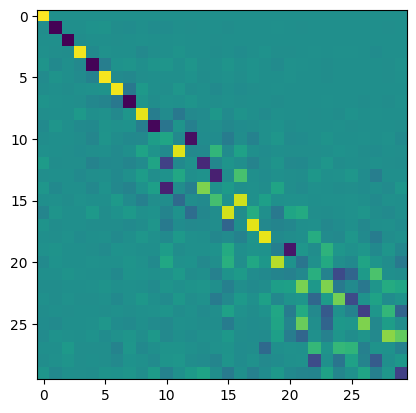

In [6]:
plt.imshow(A12)

In [7]:
# Fit KNN on eigvecs2
knn = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(eigvecs1)
distances, indices = knn.kneighbors(eigvecs2 @ A12)

p2p = indices.flatten()

In [8]:
p2p

array([   3,  188,    6, ..., 4035, 4035, 5237], shape=(6890,))

In [9]:
print("Conversion Error:", np.mean((mesh2.vertices[p2p] - mesh2.vertices) ** 2))

Conversion Error: 0.0007889982212959708


# Neural Adjoint Map

In [ ]:
emb1 = torch.tensor(eigvecs1).to(torch.float32).cuda()
emb2 = torch.tensor(eigvecs2).to(torch.float32).cuda()
nam = NeuralAdjointMap(emb1, emb2)

nam.optimize_from_p2p(p2p_gt)

emb2_nn = nam(emb2)

In [12]:
emb2_nn = nam(emb2)
knn = NearestNeighbors(n_neighbors=1, algorithm="auto").fit(eigvecs1)
distances, indices = knn.kneighbors(emb2_nn.detach().cpu().numpy())

p2p = indices.flatten()


In [14]:
p2p

array([   0,  235,    2, ..., 5235, 5239, 6889], shape=(6890,))

In [15]:
print("Conversion Error:", np.mean((mesh2.vertices[p2p] - mesh2.vertices) ** 2))

Conversion Error: 0.00026613673530906113
